In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, special

In [2]:
delta = 0.0001
w0 = 0.01
EF = 1
m = 1
h_bar = 1
kF = np.sqrt(2*m*EF) / h_bar
xi_c = 2 * EF / (kF * delta)
l_0  = 2 * EF / (kF * h_bar * w0)
print(f'kF   = {kF}')
print(f'l_0  = {l_0}')
print(f'xi_c = {xi_c}')

l_0_tilde = l_0 / xi_c
rho_0 = 1 / (2 * np.pi**2) * kF * m / h_bar**2
n = kF**3 / (6 * np.pi**2)

kF   = 1.4142135623730951
l_0  = 141.42135623730948
xi_c = 14142.13562373095


In [3]:
def w(xi):
    return 1 / ((xi / (h_bar*w0))**4 + 1)

In [7]:
def f_integral_body(r_tilde, y):
    return 1 / np.sqrt(y*y - 1) * np.exp(-r_tilde * y) / ((l_0_tilde * y)**4 + 1)

def get_residue(r_tilde):
    return -1.j * np.pi / 2 * np.exp(- r_tilde / (np.sqrt(2) * l_0_tilde)) * np.cos(r_tilde / (np.sqrt(2) * l_0_tilde))

def calc_I(r_tilde):
    integrals = np.array([integrate.quad(lambda y: f_integral_body(rt, y), 1, np.inf)[0] for rt in r_tilde])
    return integrals + get_residue(r_tilde)

def calc_f(rs):
    return 1 / (2 * np.pi**2) * kF / (xi_c * rs) * calc_I(rs / xi_c)
def calc_far_field_fs(rs):
    return 1 / (2 * np.pi**2) * kF / (xi_c * rs) * (special.k0(rs / xi_c) + get_residue(rs / xi_c))
def calc_near_field_fs(rs):
    int1, _ = integrate.quad(lambda y: 1 / (np.sqrt(y*y - 1) * ((l_0_tilde * y)**4 + 1)), 1, np.inf)
    int2, _ = integrate.quad(lambda y: y / (np.sqrt(y*y - 1) * ((l_0_tilde * y)**4 + 1)), 1, np.inf)
    return 1 / (2 * np.pi**2) * kF / (xi_c * rs) * (int1 - rs / xi_c * int2 + get_residue(rs / xi_c))

In [13]:
rs = np.exp(np.linspace(np.log(0.01 * l_0), np.log(100 * l_0), 1000))
#rs = np.linspace(0.01 * l_0, 1 * l_0, 100)
fs = calc_f(rs) / n
far_field_fs = calc_far_field_fs(rs) / n
near_field_fs = calc_near_field_fs(rs) / n

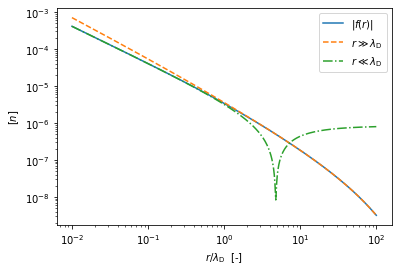

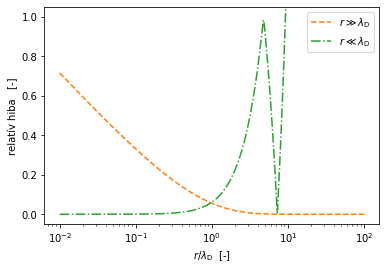

In [14]:
rs_norm = rs / l_0

plt.figure(1)
plt.loglog(rs_norm, np.abs(fs), label='$|f(r)|$')
plt.plot(rs_norm, np.abs(far_field_fs), '--', label=r'$r \gg \lambda_\mathrm{D}$')
plt.plot(rs_norm, np.abs(near_field_fs), '-.', label=r'$r \ll \lambda_\mathrm{D}$')
plt.xlabel(r'$r / \lambda_\mathrm{D}$  [-]')
plt.ylabel('$[n]$')
plt.legend()

plt.savefig("../latex/F_sc.pdf", format="pdf", bbox_inches="tight")

plt.figure(2)
plt.semilogx(rs_norm, np.abs(np.abs(fs) - np.abs(far_field_fs)) / np.abs(fs), '--', label=r'$r \gg \lambda_\mathrm{D}$', color='tab:orange')
plt.plot(rs_norm, np.abs(np.abs(fs) - np.abs(near_field_fs)) / np.abs(fs), '-.', label=r'$r \ll \lambda_\mathrm{D}$', color='tab:green')
plt.ylim([-0.05, 1.05])
plt.xlabel(r'$r / \lambda_\mathrm{D}$  [-]')
plt.ylabel('relatív hiba   [-]')
plt.legend()

plt.savefig("../latex/F_sc_error.pdf", format="pdf", bbox_inches="tight")

plt.show()